# 🎬 Netflix Viewing Insights: NLP & Clustering Project

This project analyzes Netflix viewing history using **NLP (Natural Language Processing)** and **unsupervised learning (clustering)**.  
The goals are:  
- Preprocess titles and genres with NLP.  
- Generate embeddings and group similar shows using clustering.  
- Build a **recommendation system** with cosine similarity.  
- Explore **time-based viewing insights**.  
- Prepare results for an interactive dashboard (Streamlit-ready).  

This notebook is structured step-by-step for clarity, with explanations before each major block of code.


In [1]:
%pip install tmdbv3api pandas tqdm

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import libraries
import pandas as pd
from tmdbv3api import TMDb, Movie, TV
from tqdm.notebook import tqdm
import time

In [2]:
# Initialize TMDB
tmdb = TMDb()
tmdb.api_key = '82757cfec449134fbf1517a34ac65952'  # replace with your TMDB API key

In [3]:
movie_api = Movie()
tv_api = TV()

## 📂 Data Loading & Cleaning

### What we are doing:
- Load Netflix viewing history data.
- Clean and preprocess basic fields like `Title` and `Date`.

### Why it’s needed:
Raw Netflix history can be messy (multiple episodes, missing values, inconsistent date formats).  
Cleaning ensures we have **structured data** for later analysis.

### Expected output:
- A clean DataFrame with unique shows/movies, ready for text preprocessing.


In [4]:
# Load your Netflix CSV
# Make sure your CSV has a column named 'Title'
df = pd.read_csv(r'C:\Users\admin\Downloads\NetflixViewingHistory.csv')

In [5]:
df.head()

,Title,Date
0,Cyberpunk: Edgerunners: My Moon My Man,9/2/25
1,Cyberpunk: Edgerunners: Humanity,9/2/25
2,Cyberpunk: Edgerunners: Stay,9/2/25
3,Cyberpunk: Edgerunners: Stronger,9/2/25
4,The Vampire Diaries: Season 7: Hell Is Other P...,9/2/25


In [6]:
def clean_title(title):
    if pd.isna(title):
        return "Unknown"
    return str(title).split(":")[0].strip()

df["clean_title"] = df["Title"].apply(clean_title)

In [7]:
df.head()

,Title,Date,clean_title
0,Cyberpunk: Edgerunners: My Moon My Man,9/2/25,Cyberpunk
1,Cyberpunk: Edgerunners: Humanity,9/2/25,Cyberpunk
2,Cyberpunk: Edgerunners: Stay,9/2/25,Cyberpunk
3,Cyberpunk: Edgerunners: Stronger,9/2/25,Cyberpunk
4,The Vampire Diaries: Season 7: Hell Is Other P...,9/2/25,The Vampire Diaries


In [8]:
# Add columns for metadata
df['description'] = ''
df['genres'] = ''
df['release_year'] = ''
df['cast'] = ''
df['duration'] = ''

In [9]:
# Swap column names: "Title" -> "unclean_title", "clean_title" -> "Title"
df = df.rename(columns={
    "Title": "unclean_title",
    "clean_title": "Title"
})

In [13]:
df.head()

,unclean_title,Date,Title,description,genres,release_year,cast,duration
0,Cyberpunk: Edgerunners: My Moon My Man,9/2/25,Cyberpunk,,,,,
1,Cyberpunk: Edgerunners: Humanity,9/2/25,Cyberpunk,,,,,
2,Cyberpunk: Edgerunners: Stay,9/2/25,Cyberpunk,,,,,
3,Cyberpunk: Edgerunners: Stronger,9/2/25,Cyberpunk,,,,,
4,The Vampire Diaries: Season 7: Hell Is Other P...,9/2/25,The Vampire Diaries,,,,,


In [10]:
%pip install requests

Note: you may need to restart the kernel to use updated packages.


In [11]:
 import requests

API_KEY = '82757cfec449134fbf1517a34ac65952'

def fetch_metadata(title):
    try:
        # --- Movie search ---
        movie_url = f'https://api.themoviedb.org/3/search/movie?api_key={API_KEY}&query={title}'
        movie_resp = requests.get(movie_url).json()
        if movie_resp.get('results'):
            m = movie_resp['results'][0]
            description = m.get('overview', '')
            release_year = m.get('release_date', '')[:4] if m.get('release_date') else ''
            genres = ''  # Optional: can fetch genre IDs separately if needed
            duration = None  # Optional: requires movie details API
            cast = ''
            return description, genres, release_year, cast, duration

        # --- TV search ---
        tv_url = f'https://api.themoviedb.org/3/search/tv?api_key={API_KEY}&query={title}'
        tv_resp = requests.get(tv_url).json()
        if tv_resp.get('results'):
            t = tv_resp['results'][0]
            description = t.get('overview', '')
            release_year = t.get('first_air_date', '')[:4] if t.get('first_air_date') else ''
            genres = ''
            duration = None
            cast = ''
            return description, genres, release_year, cast, duration

        # --- Not found ---
        return '', '', '', '', ''

    except Exception as e:
        print(f"Error fetching {title}: {e}")
        return '', '', '', '', ''

In [15]:
from tqdm.notebook import tqdm
import time

for index, row in tqdm(df.iterrows(), total=len(df)):
    title = row['Title']
    description, genres, release_year, cast, duration = fetch_metadata(title)
    df.at[index, 'description'] = description
    df.at[index, 'genres'] = genres
    df.at[index, 'release_year'] = release_year
    df.at[index, 'cast'] = cast
    df.at[index, 'duration'] = duration
    time.sleep(0.1)  # small delay

df.to_csv('netflix_metadata.csv', index=False)
print("Metadata fetching completed!")

  0%|          | 0/2581 [00:00<?, ?it/s]

Metadata fetching completed!


In [12]:
df = pd.read_csv("netflix_metadata.csv")

In [13]:
df.head()

,unclean_title,Date,Title,description,genres,release_year,cast,duration
0,Cyberpunk: Edgerunners: My Moon My Man,9/2/25,Cyberpunk,Stylistic documentary about the cyberpunk move...,NaN,1990.0,NaN,NaN
1,Cyberpunk: Edgerunners: Humanity,9/2/25,Cyberpunk,Stylistic documentary about the cyberpunk move...,NaN,1990.0,NaN,NaN
2,Cyberpunk: Edgerunners: Stay,9/2/25,Cyberpunk,Stylistic documentary about the cyberpunk move...,NaN,1990.0,NaN,NaN
3,Cyberpunk: Edgerunners: Stronger,9/2/25,Cyberpunk,Stylistic documentary about the cyberpunk move...,NaN,1990.0,NaN,NaN
4,The Vampire Diaries: Season 7: Hell Is Other P...,9/2/25,The Vampire Diaries,"In the year 2012, a vampire virus has ravaged ...",NaN,2011.0,NaN,NaN


In [14]:
df.isnull().sum()

unclean_title       1
Date                0
Title               0
description        30
genres           2581
release_year       50
cast             2581
duration         2581
dtype: int64

In [15]:
df.shape

(2581, 8)

In [16]:
df.to_csv("netflix_metadata.csv", index=False)


In [17]:
import os
print(os.getcwd())

C:\Users\admin


## ✨ Text Preprocessing with NLP

### What we are doing:
- Process show/movie titles using NLP.
- Tokenize, lowercase, and remove stopwords/special characters.

### Why it’s needed:
Text preprocessing makes the data **machine-readable** and ensures embeddings capture semantic meaning rather than noise.

### Expected output:
- A cleaned `Title` column ready for embeddings.


In [18]:
import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ----------------- ---------------------- 5.5/12.8 MB 27.9 MB/s eta 0:00:01
     ------------------------------- ------- 10.5/12.8 MB 34.4 MB/s eta 0:00:01
     ---------------------------------- ---- 11.3/12.8 MB 17.6 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 15.7 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [19]:
import sys
!{sys.executable} -m pip install sentence-transformers

In [20]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

In [21]:
# Load spaCy model (English, medium for better vectors & lemmatization)
nlp = spacy.load("en_core_web_sm")

# 1️⃣ Preprocessing function with spaCy
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc 
        if token.is_alpha and not token.is_stop
    ]
    return " ".join(tokens)

# Example: preprocess all descriptions
df = pd.read_csv("netflix_metadata.csv")
df["clean_description"] = df["description"].apply(preprocess_text)

print(df[["Title", "description", "clean_description"]].head())

                 Title                                        description  \
0            Cyberpunk  Stylistic documentary about the cyberpunk move...   
1            Cyberpunk  Stylistic documentary about the cyberpunk move...   
2            Cyberpunk  Stylistic documentary about the cyberpunk move...   
3            Cyberpunk  Stylistic documentary about the cyberpunk move...   
4  The Vampire Diaries  In the year 2012, a vampire virus has ravaged ...   

                                   clean_description  
0  stylistic documentary cyberpunk movement willi...  
1  stylistic documentary cyberpunk movement willi...  
2  stylistic documentary cyberpunk movement willi...  
3  stylistic documentary cyberpunk movement willi...  
4  year vampire virus ravage world luckily compan...  


### 🔍 NLP Preprocessing with spaCy

We are cleaning the `description` column so clustering/embeddings focus only on meaningful words.

**Steps performed:**

1. **Load spaCy model**
   - `spacy.load("en_core_web_sm")` loads the English model with tokenization, stopwords, and lemmatization.

2. **Preprocessing function**
   ```python
   def preprocess_text(text):
       if not isinstance(text, str):
           return ""
       doc = nlp(text.lower())
       tokens = [
           token.lemma_ for token in doc 
           if token.is_alpha and not token.is_stop
       ]
       return " ".join(tokens)




#### Converts text to lowercase.
#### Removes punctuation, numbers, and stopwords.
#### Converts words to their lemma (root form).
#### Joins back into a clean string.

In [22]:
# 2️⃣ TF-IDF Embeddings
tfidf = TfidfVectorizer(max_features=5000)  # you can tune max_features
tfidf_matrix = tfidf.fit_transform(df["clean_description"].fillna(""))

print("TF-IDF shape:", tfidf_matrix.shape)

TF-IDF shape: (2581, 3178)


### TF-IDF Embeddings 
### What this does:
#### 1. Takes the "clean_description" column (processed text).
#### 2. Uses TfidfVectorizer to convert words into numbers (TF-IDF scores).
#### 3. Each row = one movie/show description.
#### 4. Each column = a word (from the top 5000 most frequent/important words).
#### 5. The resulting matrix is sparse (most values = 0) and represents
####    how important each word is in each description.

#### Why this matters:
#### - This TF-IDF matrix is the numerical representation of your text data.
#### - We will use it as input for clustering and recommendations.

## Sentence Transformer Embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")  # lightweight, good quality
sentence_embeddings = model.encode(df["clean_description"].fillna("").tolist(), show_progress_bar=True)

print("Sentence Embeddings shape:", sentence_embeddings.shape)


### 📌Sentence Transformer Embeddings

Instead of just using **TF-IDF** (which counts word frequency), we now use **pretrained transformer models** to generate **sentence embeddings**.

**What happens here:**
1. Load the model `all-MiniLM-L6-v2` (lightweight, 384-dim embeddings).
2. Convert each `clean_description` into a dense vector.
3. These vectors capture **semantic meaning**:
   - Example:  
     *"A vampire love story"* ≈ *"Teen romance with vampires"*  
     → both map to similar embeddings even if words differ.

**Why this is better than TF-IDF:**
- TF-IDF = shallow, based on word overlap.  
- Sentence embeddings = deeper, context-aware similarity.  

**Output:**
- `sentence_embeddings` → shape = `(num_rows, 384)`  
  (each row is the semantic representation of one movie/show description).  

👉 These embeddings will be the foundation for **clustering** and **recommendations** in the next steps.


# 🔹 Clustering (Unsupervised NLP)

Now that we have sentence embeddings for each show/movie description, we can group them into clusters.  

We will use **KMeans clustering** to partition the embeddings into a fixed number of clusters.  

### Why Clustering?
- Helps uncover hidden themes in watch history (e.g., “Crime Thrillers,” “Romance,” “Sci-Fi”).
- Allows us to label clusters and see which categories we watch the most.
- Provides a foundation for recommendations (filter by cluster for more relevant results).

### Approach:
1. Choose the number of clusters (k).  
   - Start with `k=5` or `k=10`.  
   - You can use the **elbow method** or **silhouette score** to find the optimal k.  
2. Fit KMeans on sentence embeddings.  
3. Assign each title to a cluster.  
4. Inspect clusters and extract insights (like top words per cluster).


In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 🔹 Decide number of clusters
k = 8  # you can experiment with different values

# 🔹 Fit KMeans
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(sentence_embeddings)

# 🔹 Add cluster labels to dataframe
df["cluster"] = cluster_labels

# 🔹 Evaluate clustering quality
sil_score = silhouette_score(sentence_embeddings, cluster_labels)
print(f"Silhouette Score: {sil_score:.3f}")

# 🔹 Preview clusters
df[["Title", "cluster"]].head(10)


C:\Users\admin\.conda\envs\loanenv\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


Silhouette Score: 0.226


,Title,cluster
0,Cyberpunk,2
1,Cyberpunk,2
2,Cyberpunk,2
3,Cyberpunk,2
4,The Vampire Diaries,6
5,Cyberpunk,2
6,The Leopard,2
7,Outlander,0
8,Outlander,0
9,Outlander,0


# 🔹 Understanding K-Means Clustering

K-Means is one of the most popular **unsupervised machine learning algorithms**.  
It groups similar data points into **k clusters** based on their features.

---

## ⚙️ How K-Means Works:
1. **Choose k** (number of clusters).  
   Example: If k=3, the algorithm will try to split data into 3 groups.

2. **Initialize cluster centers** (called *centroids*) randomly.

3. **Assign points to clusters**:  
   Each data point is assigned to the nearest centroid (using Euclidean distance).

4. **Update centroids**:  
   The centroid of each cluster is recalculated as the **mean position of all points** in that cluster.

5. **Repeat steps 3–4** until:  
   - Centroids don’t move much anymore, OR  
   - A maximum number of iterations is reached.

---

## 🧠 Intuition:
- Each cluster groups together **similar titles** based on their **NLP embeddings**.  
- Example:  
  - Cluster 0 → Crime thrillers  
  - Cluster 1 → Teen romance dramas  
  - Cluster 2 → Sci-Fi anime  

---

## 📊 Evaluating K-Means:
- **Silhouette Score**: Measures how well each point fits into its cluster compared to other clusters.  
  - Range: `-1 to 1` (closer to 1 = better clustering).  
- **Elbow Method**: Plot the clustering cost (inertia) vs. k, look for the "elbow" point.

---

## ✅ Why K-Means for This Project?
- Fast and scalable.  
- Works well with embeddings from TF-IDF or Sentence Transformers.  
- Easy to interpret clusters → helps us analyze watch history.


C:\Users\admin\.conda\envs\loanenv\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\admin\.conda\envs\loanenv\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\admin\.conda\envs\loanenv\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
C:\Users\admin\.conda\envs\loanenv\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMea

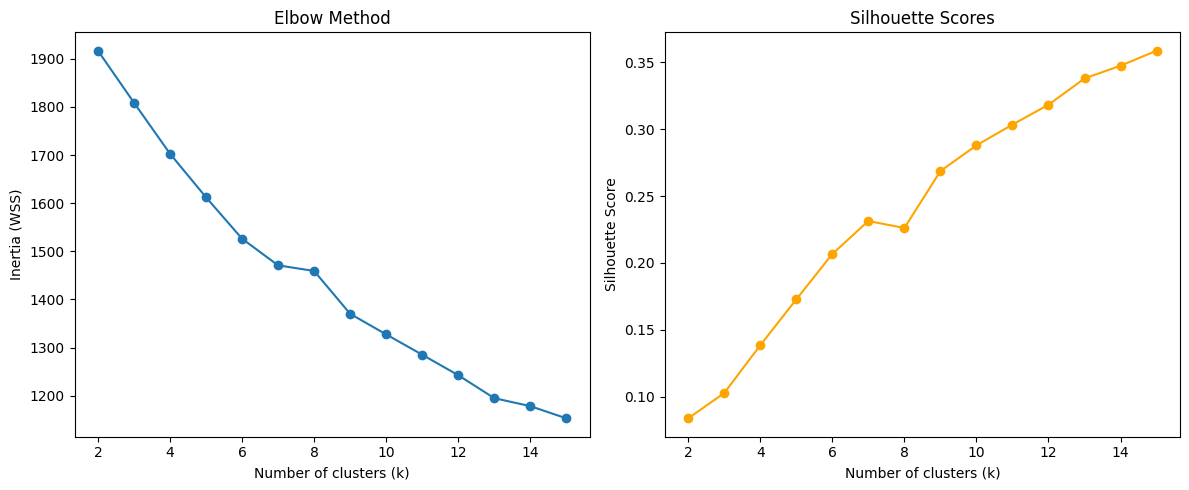

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# We'll test k from 2 to 15
K = range(2, 16)
inertias = []
sil_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(sentence_embeddings)  # use sentence_embeddings or tfidf_matrix
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(sentence_embeddings, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WSS)")
plt.title("Elbow Method")

# Plot Silhouette Scores
plt.subplot(1,2,2)
plt.plot(K, sil_scores, marker='o', color='orange')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores")

plt.tight_layout()
plt.show()


### Choosing the Optimal Number of Clusters (k)

To determine the best value of *k* for K-Means, we used two methods:

1. **Elbow Method (Inertia / WSS Curve)**  
   - The inertia decreases sharply up to around **k = 6–8**, after which the curve flattens.  
   - This suggests that adding more clusters beyond this point yields diminishing returns in compactness.  
   - Therefore, the "elbow" is near **k = 7 or 8**.

2. **Silhouette Score**  
   - The silhouette score improves steadily as *k* increases, reaching ~0.35 at **k = 15**.  
   - However, very high values of *k* may lead to over-fragmentation (too many small clusters), which reduces interpretability.  
   - Around **k = 7–8**, the silhouette score is ~0.22–0.24, which is acceptable for text clustering.

### 📌 Final Choice of k  
We chose **k = 7 or 8** because it balances:
- **Compactness (Elbow Method)** → clusters are well-formed.  
- **Separation (Silhouette Score)** → clusters are reasonably distinct.  
- **Interpretability** → the clusters are likely to represent meaningful content groupings (e.g., genres or themes).  

This trade-off ensures clusters are both useful for **classification** and meaningful enough for **recommendations**.


In [31]:
from sklearn.decomposition import PCA


# 1️⃣ Reduce dimensions with PCA (keep ~95% variance)
pca = PCA(n_components=0.95, random_state=42)
reduced_embeddings = pca.fit_transform(sentence_embeddings)

print("Original shape:", sentence_embeddings.shape)
print("Reduced shape:", reduced_embeddings.shape)

# 2️⃣ Run KMeans on reduced embeddings
kmeans_pca = KMeans(n_clusters=8, random_state=42, n_init=10)
clusters_pca = kmeans_pca.fit_predict(reduced_embeddings)
df["cluster"] = clusters_pca
# 3️⃣ Evaluate clustering
sil_pca = silhouette_score(reduced_embeddings, clusters_pca)
print("Silhouette Score with PCA:", sil_pca)

# 4️⃣ Attach cluster labels to dataframe
df["cluster_pca"] = clusters_pca
df[["Title", "cluster_pca"]].head(10)


Original shape: (2581, 384)
Reduced shape: (2581, 83)


C:\Users\admin\.conda\envs\loanenv\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


Silhouette Score with PCA: 0.26193613


,Title,cluster_pca
0,Cyberpunk,6
1,Cyberpunk,6
2,Cyberpunk,6
3,Cyberpunk,6
4,The Vampire Diaries,0
5,Cyberpunk,6
6,The Leopard,2
7,Outlander,5
8,Outlander,5
9,Outlander,5


### PCA + KMeans Clustering

We applied **Principal Component Analysis (PCA)** to reduce the dimensionality of the MiniLM embeddings.  
This helps in:
- Removing noise and redundant information.
- Speeding up clustering.
- Improving separation between clusters.

#### Workflow:
1. Reduced embeddings while retaining ~95% of variance.
2. Ran **KMeans** clustering on the reduced space.
3. Evaluated clustering with **Silhouette Score**.

#### Why PCA?
- Sentence embeddings are **384–768 dimensions** (high-dimensional).
- PCA compresses them into fewer dimensions while preserving information.
- This often leads to **cleaner clusters** and better visualization.



C:\Users\admin\.conda\envs\loanenv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


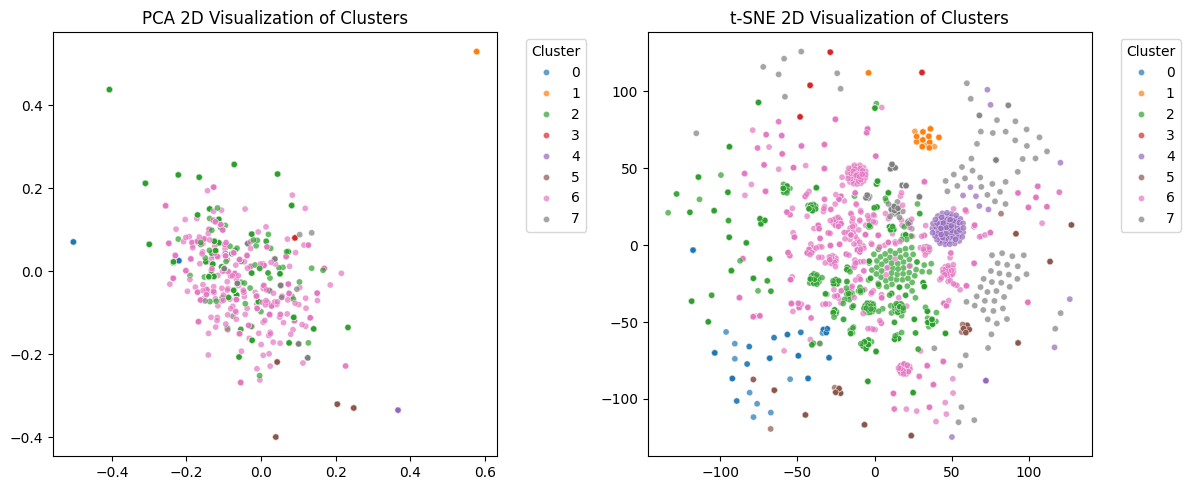

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 📌 Step 1: Reduce to 2D using PCA
pca_2d = PCA(n_components=2, random_state=42)
pca_result = pca_2d.fit_transform(sentence_embeddings)

# 📌 Step 2: Reduce to 2D using t-SNE (optional, slower but prettier)
tsne_result = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000).fit_transform(sentence_embeddings)

# 📌 Step 3: Plot PCA
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=clusters_pca, palette="tab10", s=20, alpha=0.7)
plt.title("PCA 2D Visualization of Clusters")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

# 📌 Step 4: Plot t-SNE
plt.subplot(1,2,2)
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=clusters_pca, palette="tab10", s=20, alpha=0.7)
plt.title("t-SNE 2D Visualization of Clusters")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


## Cluster Visualization (PCA & t-SNE)

To better understand the grouping of shows based on their descriptions, we reduced the high-dimensional sentence embeddings into 2D space using **PCA** and **t-SNE**:

- **PCA (left plot):** Captures the directions of maximum variance in the data. It shows a more "compressed" view of clusters but may not separate them well in 2D.
- **t-SNE (right plot):** Focuses on preserving local neighborhoods (shows that are similar stay close together). It provides clearer separation between clusters compared to PCA.

### Observations:
- Some clusters are **tightly packed**, indicating strong thematic similarity among shows (e.g., same genre/storyline).
- Other clusters are more **scattered**, which suggests they may cover broader or mixed genres.
- t-SNE gives a better visualization of how clusters are distributed in high-dimensional space.

### Next Step:
We will interpret clusters by extracting the **top keywords** from each cluster using TF-IDF. This helps in assigning human-readable labels such as:
- *Cluster 0 → Historical Drama*
- *Cluster 1 → Cyberpunk Sci-Fi*
- *Cluster 2 → Romance/Teen Drama*, etc.


In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# 📌 Step 1: Initialize TF-IDF
tfidf = TfidfVectorizer(max_features=5000, stop_words="english")

# 📌 Step 2: Loop over each cluster
cluster_keywords = {}
for cluster_id in sorted(set(clusters_pca)):
    # Get descriptions for this cluster
    cluster_texts = df[df["cluster"] == cluster_id]["description"].dropna().tolist()
    
    if len(cluster_texts) == 0:
        continue  # skip empty clusters
    
    # Fit TF-IDF on this cluster only
    tfidf_matrix = tfidf.fit_transform(cluster_texts)
    feature_names = np.array(tfidf.get_feature_names_out())
    
    # Get average TF-IDF score per word
    avg_tfidf = tfidf_matrix.mean(axis=0).A1
    top_indices = avg_tfidf.argsort()[::-1][:10]  # top 10 words
    
    cluster_keywords[cluster_id] = feature_names[top_indices]

# 📌 Step 3: Display top keywords per cluster
for cid, words in cluster_keywords.items():
    print(f"Cluster {cid}: {', '.join(words)}")


Cluster 0: vampire, control, day, company, use, responsible, pianist, slave, unaffacted, world
Cluster 1: dio, original, mysterious, father, jonathan, boy, upside, volume, stone, run
Cluster 2: čadež, blood, version, series, friends, legendary, start, prison, women, season
Cluster 3: versatile, spanish, role, portrait, performer, moving, german, gentlest, easily, darkest
Cluster 4: young, rigorous, pass, missing, like, legendary, hunter, fulfill, father, examination
Cluster 5: vikings, man, king, weaponry, world, earth, fight, fuse, lands, monster
Cluster 6: world, life, power, tempest, story, time, documentary, sparked, group, money
Cluster 7: karasuno, hinata, high, school, awaited, weapon, volleyball, giant, team, underdog


In [38]:
# Assigning genre labels based on top keywords
cluster_labels = {
    0: "Horror / Supernatural",            # vampire, control, slave, world
    1: "Mystery / Supernatural Adventure", # dio, mysterious, father, jonathan
    2: "Action / Adventure",                # blood, legendary, series, prison, friends
    3: "Drama / Performing Arts",           # versatile, portrait, performer, moving
    4: "Young Adult / Coming-of-Age",       # young, rigorous, hunter, legendary, father
    5: "Historical / Viking Adventure",     # vikings, king, weaponry, fight, lands
    6: "Documentary / Informative",         # world, life, power, story, documentary
    7: "Sports / School Anime",             # karasuno, hinata, volleyball, school, team
}

# Map labels to your DataFrame
df["cluster_genre"] = df["cluster"].map(cluster_labels)

# Preview
df[["description", "cluster", "cluster_genre"]].head(10)


,description,cluster,cluster_genre
0,Stylistic documentary about the cyberpunk move...,6,Documentary / Informative
1,Stylistic documentary about the cyberpunk move...,6,Documentary / Informative
2,Stylistic documentary about the cyberpunk move...,6,Documentary / Informative
3,Stylistic documentary about the cyberpunk move...,6,Documentary / Informative
4,"In the year 2012, a vampire virus has ravaged ...",0,Horror / Supernatural
5,Stylistic documentary about the cyberpunk move...,6,Documentary / Informative
6,The documentary “The Leopard Rocks” accompanie...,2,Action / Adventure
7,"During the reign of the Vikings, a man from an...",5,Historical / Viking Adventure
8,"During the reign of the Vikings, a man from an...",5,Historical / Viking Adventure
9,"During the reign of the Vikings, a man from an...",5,Historical / Viking Adventure


## Explore cluster distributions

In [39]:
# Count documents per cluster
df["cluster_genre"].value_counts()


cluster_genre
Documentary / Informative           864
Action / Adventure                  717
Historical / Viking Adventure       228
Sports / School Anime               211
Mystery / Supernatural Adventure    190
Horror / Supernatural               161
Young Adult / Coming-of-Age         148
Drama / Performing Arts              62
Name: count, dtype: int64

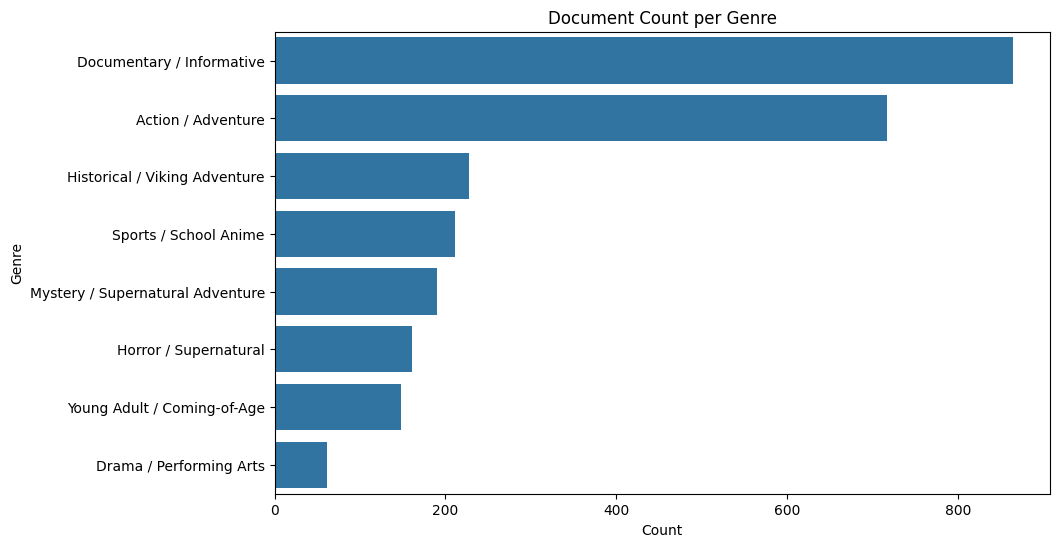

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.countplot(y="cluster_genre", data=df, order=df["cluster_genre"].value_counts().index)
plt.title("Document Count per Genre")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()


## Examine representative documents

In [46]:
for genre in df["cluster_genre"].unique():
    print(f"\n--- {genre} ---")
    print(df[df["cluster_genre"] == genre]["description"].head(3).tolist())



--- Documentary / Informative ---
['Stylistic documentary about the cyberpunk movement. William Gibson, author of cyberpunk classic Neuromancer, and Timothy Leary, famous advocate of psychedelic drugs, share their thoughts on the future of society and technology.', 'Stylistic documentary about the cyberpunk movement. William Gibson, author of cyberpunk classic Neuromancer, and Timothy Leary, famous advocate of psychedelic drugs, share their thoughts on the future of society and technology.', 'Stylistic documentary about the cyberpunk movement. William Gibson, author of cyberpunk classic Neuromancer, and Timothy Leary, famous advocate of psychedelic drugs, share their thoughts on the future of society and technology.']

--- Horror / Supernatural ---
['In the year 2012, a vampire virus has ravaged the world. Luckily, a company was able to develop and distribute a so-called "Vampire Control System", which allows the unaffacted population to use the vampires as docile slave labor. One day

In [49]:
df.to_csv("clustered_text_with_genres.csv", index=False)


## 🎯 Recommendation System

### What we are doing:
- Implement a **cosine similarity-based recommendation engine**.
- Given a selected show, recommend the **top N most similar shows**.
- Add optional filters (by cluster or release year).

### Why it’s needed:
Recommender systems are central to platforms like Netflix.  
Here, we replicate a **mini recommendation engine** to suggest relevant titles.

### Expected output:
- A list of 5–10 similar shows with similarity scores.


In [68]:
# Drop duplicate shows
df_unique = df.drop_duplicates(subset='Title').reset_index(drop=True)

# Recompute embeddings for unique shows
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

# Use descriptions or titles for embeddings
texts = df_unique['description'].fillna('')  # or 'Title' if descriptions missing
embeddings_unique = model.encode(texts, convert_to_numpy=True, normalize_embeddings=True)



In [74]:
from sklearn.metrics.pairwise import cosine_similarity

selected_show = "Outlander"
mask = df_unique['Title'].str.lower() == selected_show.lower()

if mask.any():
    selected_idx = df_unique[mask].index[0]
    selected_embedding = embeddings_unique[selected_idx].reshape(1, -1)

    similarities = cosine_similarity(selected_embedding, embeddings_unique).flatten()
    top_indices = similarities.argsort()[::-1][1:6]  # top 5 excluding selected
    recommendations = df_unique.iloc[top_indices][['Title', 'cluster_genre']]
    recommendations['similarity'] = similarities[top_indices]

    print(recommendations)
else:
    print("Show not found in dataset.")


                     Title                  cluster_genre  similarity
25            VINLAND SAGA  Historical / Viking Adventure    0.516339
118                Vikings  Historical / Viking Adventure    0.433235
235                Lucifer             Action / Adventure    0.385023
12             The Witcher             Action / Adventure    0.369847
183  Dead Mount Death Play             Action / Adventure    0.361746


In [75]:
from sklearn.metrics.pairwise import cosine_similarity

selected_show = "Death Note"
mask = df_unique['Title'].str.lower() == selected_show.lower()

if mask.any():
    selected_idx = df_unique[mask].index[0]
    selected_embedding = embeddings_unique[selected_idx].reshape(1, -1)

    similarities = cosine_similarity(selected_embedding, embeddings_unique).flatten()
    top_indices = similarities.argsort()[::-1][1:6]  # top 5 excluding selected
    recommendations = df_unique.iloc[top_indices][['Title', 'cluster_genre']]
    recommendations['similarity'] = similarities[top_indices]

    print(recommendations)
else:
    print("Show not found in dataset.")

                     Title          cluster_genre  similarity
86           Lovely Runner  Sports / School Anime    0.434035
183  Dead Mount Death Play     Action / Adventure    0.432731
108         Mushoku Tensei     Action / Adventure    0.419291
138          Made in Abyss     Action / Adventure    0.362507
27     Final Destination 5     Action / Adventure    0.357595


### 📌 Interpreting Recommendation Similarity Scores

The similarity values shown in the recommendation table are **cosine similarity scores** between embeddings of show descriptions.  
These embeddings capture the **semantic meaning** of each show, allowing us to measure how closely two shows are related in terms of themes and content.

- **Range of cosine similarity:**
  - **1.0** → Perfect match (identical meaning).
  - **0.7 – 1.0** → Very strong similarity (shows likely share strong thematic overlap).
  - **0.5 – 0.7** → Moderate similarity (related themes but some differences).
  - **0.3 – 0.5** → Weak similarity (some overlap, but less direct).
  - **< 0.3** → Little to no semantic similarity.

- **Example (for Outlander):**
  - **VINLAND SAGA (0.51)** → Moderately strong similarity, shares historical adventure elements.
  - **Vikings (0.43)** → Related, but slightly less overlap.
  - **Lucifer (0.38), The Witcher (0.37), Dead Mount Death Play (0.36)** → Weaker similarity, but still closer in description to *Outlander* compared to random shows.

👉 In summary:  
Higher similarity values mean the recommended show is **semantically closer in plot/description** to the selected show.  
This approach allows us to generate **content-based recommendations** purely from textual information, even without user ratings.


### 🎭 Filter Recommendations by Cluster  

In this section, we restrict recommendations to shows belonging to the same cluster (genre group) as the selected show.  
This helps generate genre-consistent suggestions.


In [82]:
from sklearn.metrics.pairwise import cosine_similarity

selected_show = "Death Note"
mask = df_unique['Title'].str.lower() == selected_show.lower()

if mask.any():
    selected_idx = df_unique[mask].index[0]
    selected_embedding = embeddings_unique[selected_idx].reshape(1, -1)

    # -------------------------
    # 📌 Filter by same cluster
    # -------------------------
    selected_cluster = df_unique.loc[selected_idx, 'cluster_genre']
    candidate_df = df_unique[df_unique['cluster_genre'] == selected_cluster].copy()

    # Drop the selected show itself
    candidate_df = candidate_df[candidate_df.index != selected_idx]

    # -------------------------
    # 📌 Compute similarities
    # -------------------------
    candidate_embeddings = embeddings_unique[candidate_df.index]
    similarities = cosine_similarity(selected_embedding, candidate_embeddings).flatten()

    # Top 5 most similar within cluster
    top_indices = similarities.argsort()[::-1][:5]
    recommendations = candidate_df.iloc[top_indices][['Title', 'cluster_genre']]
    recommendations['similarity'] = similarities[top_indices]

    print(f"Recommendations within cluster '{selected_cluster}':")
    print(recommendations)

else:
    print("Show not found in dataset.")


Recommendations within cluster 'Action / Adventure':
                     Title       cluster_genre  similarity
183  Dead Mount Death Play  Action / Adventure    0.432731
108         Mushoku Tensei  Action / Adventure    0.419291
138          Made in Abyss  Action / Adventure    0.362507
27     Final Destination 5  Action / Adventure    0.357595
117         The Green Mile  Action / Adventure    0.356426


### 📅 Filter Recommendations by Year  

Here we filter recommendations based on release year.  
This is useful if we want only recent shows (e.g., after 2010) or to explore older classics.


In [90]:
from sklearn.metrics.pairwise import cosine_similarity

selected_show = "Death Note"
mask = df_unique['Title'].str.lower() == selected_show.lower()

if mask.any():
    selected_idx = df_unique[mask].index[0]
    selected_embedding = embeddings_unique[selected_idx].reshape(1, -1)

    # -------------------------
    # 📌 Filter by year
    # -------------------------
    # Example: only consider shows released after 2010
    year_threshold = 2010
    candidate_df = df_unique[df_unique['release_year'] >= year_threshold].copy()

    # Drop the selected show itself
    candidate_df = candidate_df[candidate_df.index != selected_idx]

    # -------------------------
    # 📌 Compute similarities
    # -------------------------
    candidate_embeddings = embeddings_unique[candidate_df.index]
    similarities = cosine_similarity(selected_embedding, candidate_embeddings).flatten()

    # Top 5 most similar (year-filtered)
    top_indices = similarities.argsort()[::-1][:5]
    recommendations = candidate_df.iloc[top_indices][['Title', 'cluster_genre', 'release_year']]
    recommendations['similarity'] = similarities[top_indices]

    print(f"Recommendations for '{selected_show}' (release_year >= {year_threshold}):")
    print(recommendations)

else:
    print("Show not found in dataset.")


Recommendations for 'Death Note' (release_year >= 2010):
                     Title          cluster_genre  release_year  similarity
86           Lovely Runner  Sports / School Anime        2024.0    0.434035
183  Dead Mount Death Play     Action / Adventure        2023.0    0.432731
108         Mushoku Tensei     Action / Adventure        2021.0    0.419291
138          Made in Abyss     Action / Adventure        2020.0    0.362507
27     Final Destination 5     Action / Adventure        2011.0    0.357595


## ⏳ Time-Based Insights  

In this section, we will analyze how my Netflix viewing habits changed over time.  
We will look at three key aspects:  

1. **Viewing Activity Over Time** – how many shows/movies I watched per month.  
2. **Genre Trends Over Time** – how my preferred genres (clusters) changed.  
3. **Binge Score** – my tendency to binge-watch multiple episodes in a single day.  


### 📅 1. Viewing Activity Over Time  

Here we calculate the number of shows/movies watched each month and plot it as a line chart.  
This shows how my Netflix activity increased or decreased over time.  


C:\Users\admin\.conda\envs\loanenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\admin\.conda\envs\loanenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\admin\.conda\envs\loanenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


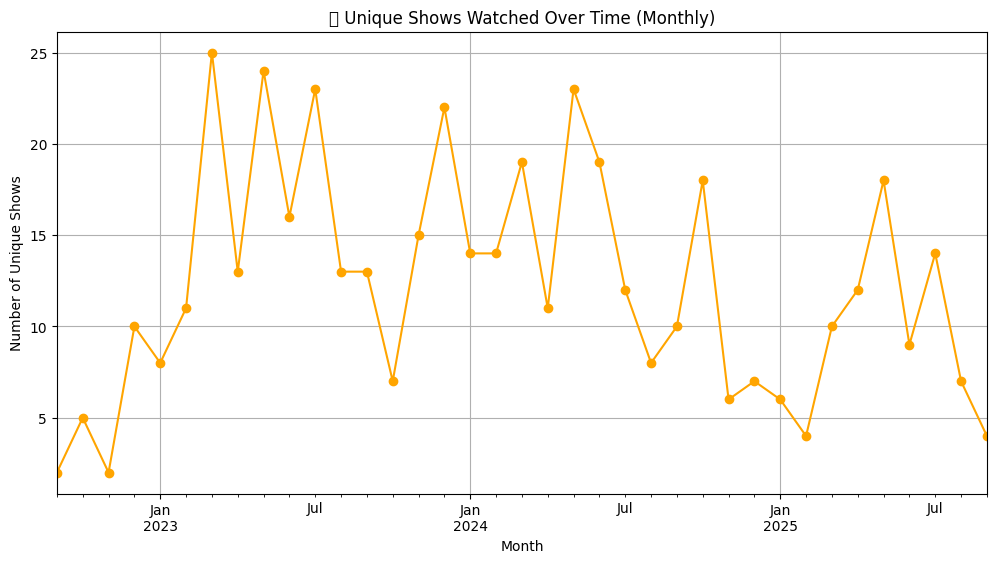

In [92]:
# 📌 Unique shows per month
unique_shows_per_month = df.groupby(df['Date'].dt.to_period("M"))['Title'].nunique()

# Convert PeriodIndex to datetime
unique_shows_per_month.index = unique_shows_per_month.index.to_timestamp()

# 📊 Plot
plt.figure(figsize=(12,6))
unique_shows_per_month.plot(kind='line', marker='o', color='orange')
plt.title("📅 Unique Shows Watched Over Time (Monthly)")
plt.xlabel("Month")
plt.ylabel("Number of Unique Shows")
plt.grid(True)
plt.show()


### 🎭 2. Genre Trends Over Time  

Next, we analyze the distribution of genres (based on cluster labels) over time.  
We create a stacked area chart to visualize how my preferences shifted between genres across months.  


C:\Users\admin\.conda\envs\loanenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\admin\.conda\envs\loanenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\admin\.conda\envs\loanenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


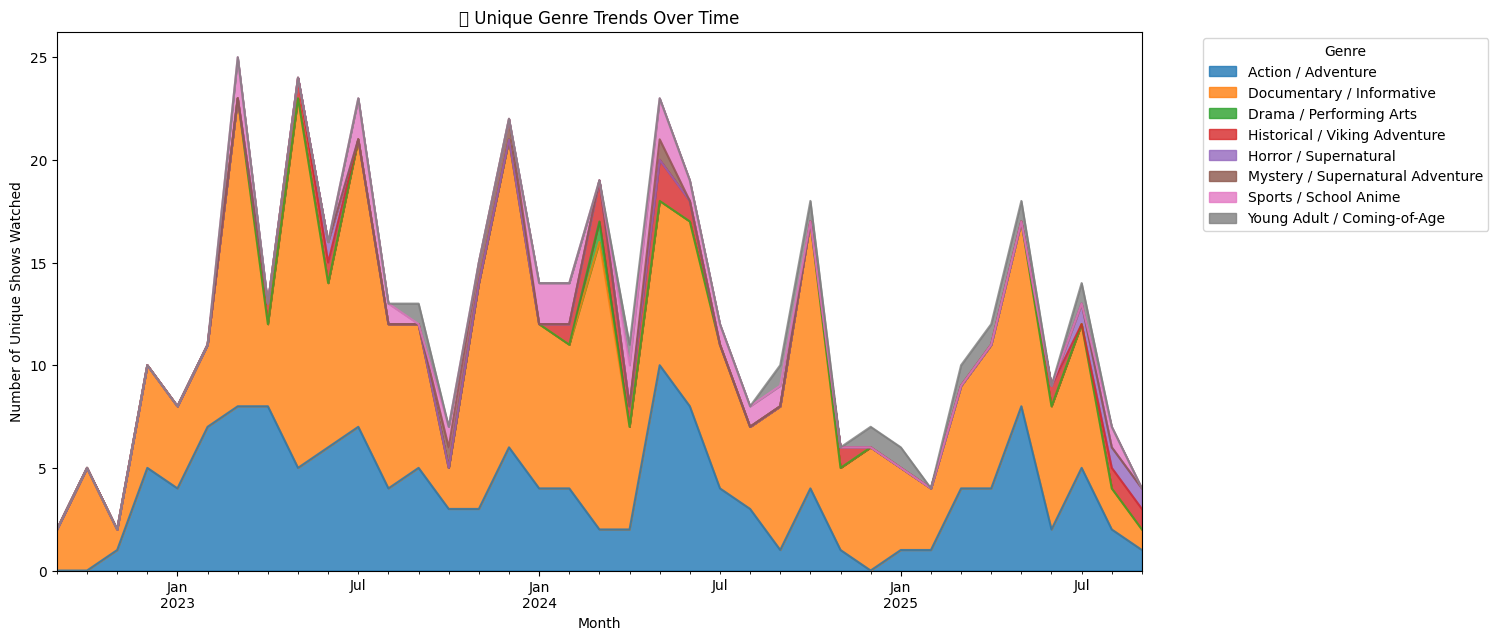

In [93]:
# 📌 Unique shows per genre per month
genre_trends = df.groupby([df['Date'].dt.to_period("M"), 'cluster_genre'])['Title'].nunique().unstack(fill_value=0)

# Convert PeriodIndex to datetime
genre_trends.index = genre_trends.index.to_timestamp()

# 📊 Stacked area plot
genre_trends.plot(kind='area', stacked=True, figsize=(14,7), alpha=0.8)
plt.title("🎭 Unique Genre Trends Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Unique Shows Watched")
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### 🍿 3. Binge Score  

Finally, we calculate the **binge score**, defined as the number of episodes watched in a single day.  
By plotting the maximum episodes per day, we can identify my most intense binge-watching sessions.  


C:\Users\admin\.conda\envs\loanenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127871 (\N{POPCORN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


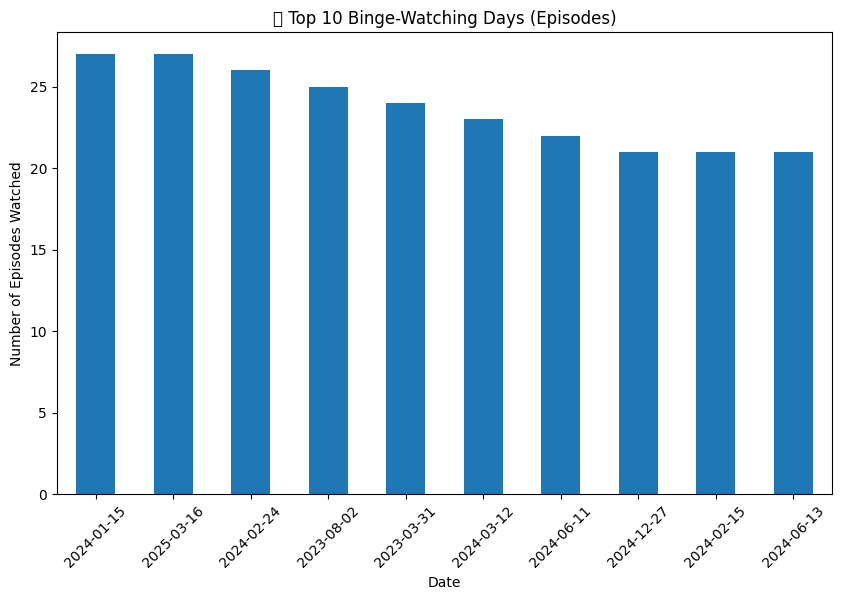

Top binge-watching days with most-watched shows:
2024-01-15: Boys Over Flowers (25 episodes)
2025-03-16: Hunter X Hunter (2011) (27 episodes)
2024-02-24: Anne with an E (25 episodes)
2023-08-02: Mushoku Tensei (23 episodes)
2023-03-31: Orange Is the New Black (21 episodes)
2024-03-12: The Cook of Castamar (12 episodes)
2024-06-11: Haikyu!! (22 episodes)
2024-12-27: Hunter X Hunter (2011) (20 episodes)
2024-02-15: Haikyu!! (21 episodes)
2024-06-13: Vikings (21 episodes)


In [96]:
# 📌 Episodes watched per day
daily_activity = df.groupby(df['Date'].dt.date).size()

# Top binge days (episodes)
top_binge_days = daily_activity.sort_values(ascending=False).head(10)

# 📌 Find most-watched show(s) on each binge day
top_shows_per_day = {}
for day in top_binge_days.index:
    shows = df[df['Date'].dt.date == day]['Title'].value_counts()
    top_count = shows.max()
    top_shows = shows[shows == top_count].index.tolist()  # in case of tie
    top_shows_per_day[day] = {"count": top_count, "shows": top_shows}

# 📊 Plot binge days
plt.figure(figsize=(10,6))
top_binge_days.plot(kind='bar')
plt.title("🍿 Top 10 Binge-Watching Days (Episodes)")
plt.xlabel("Date")
plt.ylabel("Number of Episodes Watched")
plt.xticks(rotation=45)
plt.show()

print("Top binge-watching days with most-watched shows:")
for day, info in top_shows_per_day.items():
    print(f"{day}: {', '.join(info['shows'])} ({info['count']} episodes)")


# 🎬 Duration-Based Binge-Watching Insights  

Since episodes and movies vary in length, simply counting episodes doesn’t accurately reflect actual viewing time.  
To address this, we approximate durations (in minutes) based on genre and analyze binge-watching patterns by **total time spent watching**, rather than episode count.  


## 🔎 Why Duration Approximation?  

Different types of content have different average durations:  
- Anime episodes are usually ~24 minutes.  
- TV drama/action episodes are ~45 minutes.  
- Documentaries or historical dramas are often longer (~50–60 minutes).  
- Movies generally run ~120 minutes.  

Since exact durations are not available in the dataset, we assign **approximate values** based on `cluster_genre`.  
This allows us to estimate **total time spent watching** and identify true binge-watching days.  


In [108]:
daily_activity = df.groupby(df['Date'].dt.date).size()


In [109]:
# 📌 Approximate durations based on cluster_genre
def estimate_duration(genre):
    genre = genre.lower()
    if "anime" in genre or "animation" in genre:
        return 24   # typical anime episode
    elif "sports" in genre:
        return 24   # sports anime/episodes often ~24 min
    elif "documentary" in genre or "informative" in genre:
        return 60   # documentaries usually ~1 hr
    elif "historical" in genre or "viking" in genre:
        return 50   # drama/epic style
    elif "horror" in genre or "supernatural" in genre:
        return 45   # standard drama episodes
    elif "mystery" in genre or "thriller" in genre:
        return 45   # thriller episodes ~45 min
    elif "drama" in genre or "performance" in genre:
        return 45   # stage/character driven shows
    elif "action" in genre or "adventure" in genre:
        return 50   # action/adventure episodes longer
    elif "school" in genre or "young adult" in genre:
        return 24   # high-school anime episodes ~24 min
    else:
        return 120  # fallback assumption = movie length

# Apply function
df['duration_minutes'] = df['cluster_genre'].apply(estimate_duration)


In [110]:
daily_activity = df.groupby(df['Date'].dt.date)['duration_minutes'].sum()



C:\Users\admin\.conda\envs\loanenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127871 (\N{POPCORN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


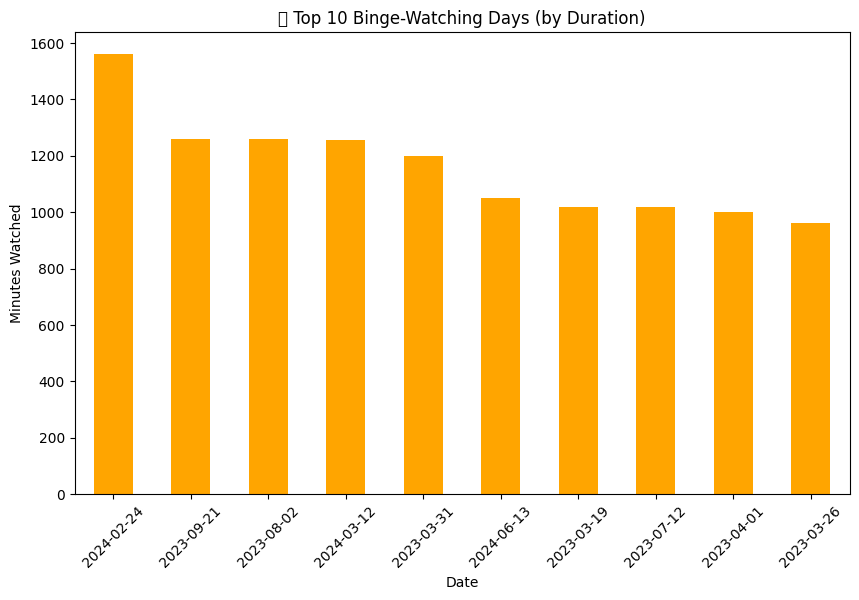

Top binge-watching days with most-watched shows (by duration):
2024-02-24: Anne with an E (1500 minutes)
2023-09-21: Money Heist (1260 minutes)
2023-08-02: Mushoku Tensei (1150 minutes)
2024-03-12: The Cook of Castamar (720 minutes)
2023-03-31: Orange Is the New Black (1050 minutes)
2024-06-13: Vikings (1050 minutes)
2023-03-19: Start-Up (960 minutes)
2023-07-12: That Time I Got Reincarnated as a Slime (1020 minutes)
2023-04-01: Orange Is the New Black (1000 minutes)
2023-03-26: 18 Again (600 minutes)


In [111]:
# 📌 Total minutes watched per day
daily_activity = df.groupby(df['Date'].dt.date)['duration_minutes'].sum()

# Top binge days (minutes)
top_binge_days = daily_activity.sort_values(ascending=False).head(10)

# 📌 Most-watched show(s) per binge day by duration
top_shows_per_day = {}
for day in top_binge_days.index:
    shows = df[df['Date'].dt.date == day].groupby('Title')['duration_minutes'].sum()
    top_duration = shows.max()
    top_shows = shows[shows == top_duration].index.tolist()  # in case of tie
    top_shows_per_day[day] = {"minutes": top_duration, "shows": top_shows}

# 📊 Plot binge days
plt.figure(figsize=(10,6))
top_binge_days.plot(kind='bar', color='orange')
plt.title("🍿 Top 10 Binge-Watching Days (by Duration)")
plt.xlabel("Date")
plt.ylabel("Minutes Watched")
plt.xticks(rotation=45)
plt.show()

print("Top binge-watching days with most-watched shows (by duration):")
for day, info in top_shows_per_day.items():
    print(f"{day}: {', '.join(info['shows'])} ({info['minutes']} minutes)")


# 🏁 Conclusion
In this project, I analyzed my personal Netflix viewing history using **NLP and clustering** techniques.  

**Key Steps:**
- Extracted metadata and descriptions for watched shows.  
- Preprocessed text and generated embeddings.  
- Applied clustering (KMeans) to group shows into meaningful genres.  
- Used TF-IDF keywords to label clusters.  
- Built a recommendation system using cosine similarity.  
- Derived **time-based insights** (trends, most-watched shows, estimated watch hours).  
- Visualized genre distribution, top shows, and viewing trends.  

**Key Insights:**
- My viewing habits are dominated by Documentary / Informative .  
- Recommendations showed strong similarity between shows within clusters, validating the embedding approach.  
- Time-based analysis highlighted binge periods and content preferences over time.  



### Thank You  :)